# LOB exploration

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import pylab as plt
import LOB_analysis  #helper functions for loading data

## Data Loading. 
Let us load only one day of data for the `AMD` stoch on the data `2020-01-02`

In [2]:
msg_file = '../data/AMD_2020-01-02_24900000_57900000_message_10.csv'
order_book = '../data/AMD_2020-01-02_24900000_57900000_orderbook_10.csv'

message = LOB_analysis.load_message(msg_file)
LOB = LOB_analysis.load_LOB(order_book)

In [3]:
message.head()

,time,type,id,vol,price,direct
0,12713.562747,7,0,0,1,-1
1,14400.121165,1,42733,5000,461200,1
2,14417.503762,1,97513,60,500800,-1
3,14418.843253,1,97665,100,461100,1
4,14418.843425,1,97669,100,461300,1


### Each transaction has: 
1. a time stamp (when transaction occured) expressed in seconds since midnight
2. type of transactions:
        Event Type:
        1: Submission of a new limit order
        2: Cancellation (partial deletion of a limit order)
        3: Deletion (total deletion of a limit order)
        4: Execution of a visible limit order
        5: Execution of a hidden limit order
        6: Indicates a cross trade, e.g. auction trade
        7: Trading halt indicator (detailed information below)
3. the Id of the transaction
4. volume (how many stocks were transacted) and at what price
5. direction:  
        +1: indicats: BUY order // seller initiated trade (a seller takes the initiative to consume some of the quoted offers at the BID// The volume at the BID decreases 
        -1: indicates: SELL order // buyer initiated trade (a buyer takes the initiative to consume some of the quoted offers at the ASK// The volume at the ASK decreases 
**CAREFUL: Execution of a sell (buy) limit order corresponds to a buyer (seller) initiated trade, i.e. buy (sell) trade.**  


see: https://lobsterdata.com/info/DataStructure.php

In [10]:
LOB.head()

,ask_price_1,ask_size_1,bid_price_1,bid_size_1,ask_price_2,ask_size_2,bid_price_2,bid_size_2,ask_price_3,ask_size_3,...,bid_price_8,bid_size_8,ask_price_9,ask_size_9,bid_price_9,bid_size_9,ask_price_10,ask_size_10,bid_price_10,bid_size_10
0,9999999999,0,-9999999999,0,9999999999,0,-9999999999,0,9999999999,0,...,-9999999999,0,9999999999,0,-9999999999,0,9999999999,0,-9999999999,0
1,9999999999,0,461200,5000,9999999999,0,-9999999999,0,9999999999,0,...,-9999999999,0,9999999999,0,-9999999999,0,9999999999,0,-9999999999,0
2,500800,60,461200,5000,9999999999,0,-9999999999,0,9999999999,0,...,-9999999999,0,9999999999,0,-9999999999,0,9999999999,0,-9999999999,0
3,500800,60,461200,5000,9999999999,0,461100,100,9999999999,0,...,-9999999999,0,9999999999,0,-9999999999,0,9999999999,0,-9999999999,0
4,500800,60,461300,100,9999999999,0,461200,5000,9999999999,0,...,-9999999999,0,9999999999,0,-9999999999,0,9999999999,0,-9999999999,0


In [11]:
# Let us only keep the transaction that occued during trading time in between 9:30 and 16:00
index_valid_bool = ( message["time"] / 3600 > 9.5 ) & ( message["time"] / 3600 < 16.0 )
LOB = LOB[index_valid_bool]
message = message[index_valid_bool]

### Display the limit order book prices

Text(0, 0.5, 'Price')

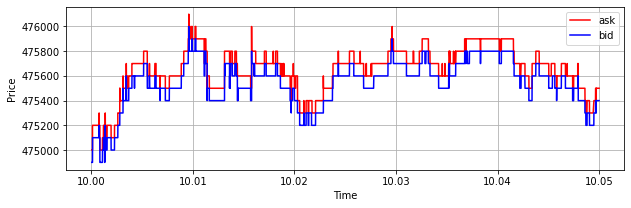

In [12]:
# let us display the BID/ASK proces in between t0 and t1
t0 = 10.00 # time expressed in hours
t1 = 10.05 # time
time_indices_bool = (message["time"] >= t0*3600) & (message["time"] < t1*3600)

plt.figure(figsize=(10,3))
plt.plot( message["time"][time_indices_bool].values / 3600, LOB["ask_price_1"][time_indices_bool] , "r-", label="ask")
plt.plot( message["time"][time_indices_bool].values / 3600, LOB["bid_price_1"][time_indices_bool] , "b-", label="bid")
plt.legend()

plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Price")

Text(0, 0.5, 'Price')

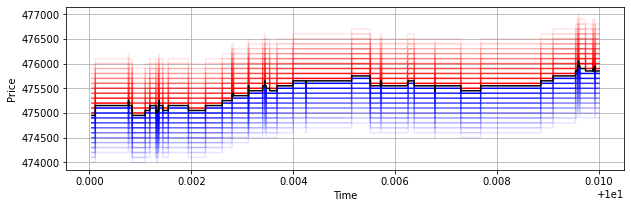

In [13]:
# let us display the limit order book proces
t0 = 10.00 # time expressed in hours
t1 = 10.01 # time
time_indices_bool = (message["time"] >= t0*3600) & (message["time"] < t1*3600)

plt.figure(figsize=(10,3))
for k in range(1,11):
    plt.plot( message["time"][time_indices_bool].values / 3600, LOB[f"ask_price_{k}"][time_indices_bool], "r-", alpha = 1.1 - k/10)
    plt.plot( message["time"][time_indices_bool].values / 3600, LOB[f"bid_price_{k}"][time_indices_bool], "b-", alpha = 1.1 - k/10)

# display midprice
mid = (LOB[f"ask_price_1"][time_indices_bool] + LOB[f"bid_price_1"][time_indices_bool])/2.
plt.plot( message["time"][time_indices_bool].values / 3600, mid, "k-")


plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Price")

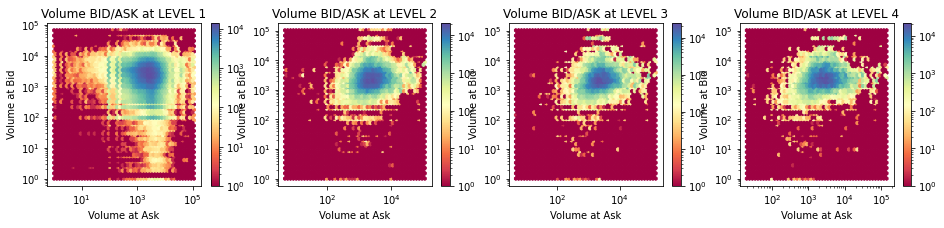

In [14]:
# Let us look at the imbalance between the volume at BID and ASK
plt.figure(figsize=(20,3))
for k in range(1,5):
    plt.subplot(1,5,k)

    plt.hexbin(LOB[f"ask_size_{k}"], LOB[f"bid_size_{k}"], 
               gridsize=50, cmap='Spectral',
               xscale="log", yscale="log", bins='log')
    plt.colorbar()
    plt.title(f"Volume BID/ASK at LEVEL {k}")
    plt.xlabel("Volume at Ask")
    plt.ylabel("Volume at Bid")

## Sanity check: market order are less or equal to available volume

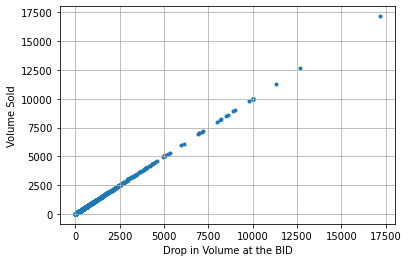

In [15]:
# SANITY CHECK
# Carefull: Execution of a sell (buy) limit order corresponds to a buyer (seller) 
#           initiated trade, i.e. buy (sell) trade.
# After a BUY order (i.e.  SELLER initiated trade --> the seller sells some stocks to some of the buyer 
# and some volume at the BID is consumed)

index_buy_bool = (message["type"] == 4) & (message["direct"] == 1)
index_buy = np.arange(len(message))[ index_buy_bool ]

# because if the buyer buys all the quantity available, the bid price will change
# the proce in the LOB is the price immediately **after** the operation has been 
# executed. Let us concentrate on the operation that do not change the BID price
index_do_not_change_bid_price_bool = message.price.values[index_buy] == LOB.bid_price_1.values[index_buy]
index_buy = index_buy[index_do_not_change_bid_price_bool]

# extract volume bought
volumes = message["vol"].values
volume_sold = volumes[index_buy]

# extract how much the volume at the BID price dropped
delta_volume = LOB.bid_size_1.values[index_buy-1] - LOB.bid_size_1.values[index_buy]

# if everything is OK, we should have: volume_bought == delta_volume
plt.scatter(delta_volume, volume_sold, marker=".")
plt.xlabel("Drop in Volume at the BID")
plt.ylabel("Volume Sold")
plt.grid(True)

In [47]:
# SANITY CHECK
# if everything is OK, for each transaction BUY transaction, 
# the message[price] of the trade should be equal to the BID price recorded 
# in the LOB immediately before
index_buy_bool = (message["type"] == 4) & (message["direct"] == 1)
index_buy = np.arange(len(message))[ index_buy_bool ]

is_all_equal = np.all(message["price"].values[index_buy] == LOB["bid_price_1"].values[index_buy-1])
print(f"Sanity check: {is_all_equal}")

Sanity check: True


# Imbalance and price movement
We would like to study the direction of the next price movement and correlate it with the volume imbalance $I=V_{bid} / [V_{bid} + V_{ask}]$.

In [34]:
# find out indices when ask-price just went up or bidprice just went down
index_ask_up = np.arange(1,len(LOB))[LOB.ask_price_1.values[1:] > LOB.ask_price_1.values[:-1]]
index_bid_down = np.arange(1,len(LOB))[LOB.bid_price_1.values[1:] < LOB.bid_price_1.values[:-1]]

# label each and every rows according to the direction of the next price movement
next_move = np.zeros(len(LOB))
next_move[index_ask_up-1] = 1
next_move[index_bid_down-1] = -1

sign = 0
for k in np.arange(len(LOB))[::-1]:
    if next_move[k] != 0:
        sign = next_move[k]
    next_move[k] = sign

Text(0, 0.5, 'sign(next price movement)')

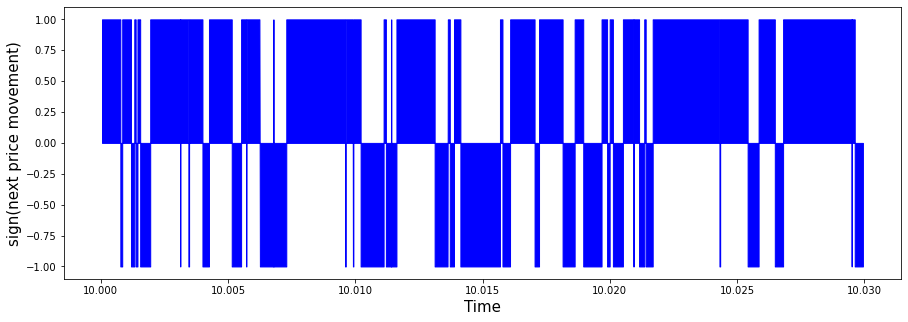

In [35]:
t0 = 10.00 # time expressed in hours
t1 = 10.03 # time
time_indices_bool = (message["time"] >= t0*3600) & (message["time"] < t1*3600)
time_indices = np.arange(len(LOB))[time_indices_bool]


plt.figure(figsize=(15,5))
plt.fill_between(message.time[time_indices_bool] / 3600.,
                 next_move[time_indices], color="blue")
plt.xlabel("Time", fontsize=15)
plt.ylabel("sign(next price movement)", fontsize=15)

In [298]:
# Let us compute the probability that the next price movement
# is **UP** as a function of the imbalance
# if there is a lot of volume at the BID price, this means 
# that there is a lot of people willing to BUY the stock. 
# This demand leads to an increase in price
# summary: when vol(BID)>>vol(ASK) the next price movement is more often UP

imbalance = LOB.bid_size_1 / (LOB.ask_size_1+LOB.bid_size_1)
imbalance = imbalance.values
bins_limits = np.linspace(0,1,100)
center_list = []
proba_up_list = []
for k in range(1,len(bins_limits)):
    left, right = bins_limits[k-1], bins_limits[k]
    center = (left + right)/2.
    center_list.append(center)
    proba_up = np.mean( next_move[(imbalance >= left) & (imbalance < right)] == 1 )
    proba_up_list.append(proba_up)

(0.0, 1.0)

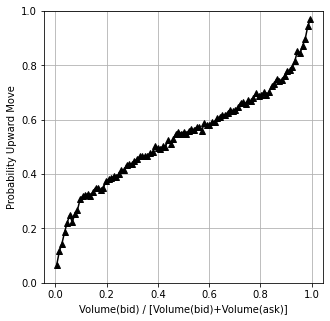

In [299]:
plt.figure(figsize=(5,5))

plt.plot(center_list , proba_up_list, "k-^")
#plt.plot(bins_limits, bins_limits, "r--", alpha=0.5)
plt.grid(True)
plt.xlabel("Volume(bid) / [Volume(bid)+Volume(ask)]")
plt.ylabel("Probability Upward Move")
plt.ylim(0,1)

# Market impact

In [300]:
# find out indices when the where a marker order leading to buy/sell of stockas
# after a BUY order (message.direct == 1:
# ----> seller initiates trade and consume some of the stock at the BID
# ----> Volume at BID decreases
# ----> mid price remains the same or goes DOWN
index_down = np.arange(0,len(LOB))[ (message.type.values == 4) & (message.direct == 1)]
index_up = np.arange(0,len(LOB))[ (message.type.values == 4) & (message.direct == -1)]

# trim the starts/end
index_down = index_down[1000:-1000]
index_up = index_up[1000:-1000]

In [301]:
# we would like to know to compute the expected price change 
# (delta) steps in the future after a buy or sell order

delta_list = range(1,100)
mid = (LOB.ask_price_1.values + LOB.bid_price_1.values)/2.
impact_down = []
impact_up = []
for delta in delta_list:
    impact = np.mean( mid[index_down+delta] - mid[index_down] )
    impact_down.append(impact / 100.)
    
    impact = np.mean( mid[index_up+delta] - mid[index_up] )
    impact_up.append(impact / 100.)

Text(0.5, 1.0, 'Market Impact')

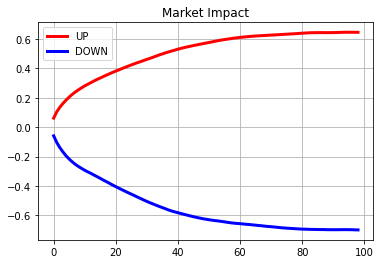

In [302]:
# we see below that on average, after a BUY order (buyer initiates a buy)
# the price continues to go down for quite some time
# it is eplained by the fact that buyers often needs to purchase a large 
# quantity of stocks and initiate many buys orders in a row

plt.plot(impact_up, "r-", lw=3, label="UP")
plt.plot(impact_down, "b-", lw=3, label="DOWN")
plt.legend()
plt.grid(True)
plt.title("Market Impact")

### Doug: This is indicative of autocorrelation, correct? I.e. a graph where given that it went down, is more likely to go down, same for up.

# Volume of transaction throughout the day

In [303]:
indices_market_order = np.arange(len(LOB))[message.type == 4]

In [304]:
time_slices = np.linspace(9.5, 16.0, 30)
time_list = []
activity_list = []
volume_list = []

for k in range(1, len(time_slices)):
    t_start, t_end = time_slices[k-1], time_slices[k]
    indices_slice = ( message.time / 3600 > t_start ) & ( message.time / 3600 < t_end ) & (message.type == 4)
    volume = np.sum( message.vol[indices_slice] )
    activity = np.sum(indices_slice)
    time_list.append( (t_start+t_end)/2. )
    activity_list.append(activity)
    volume_list.append(volume)
    
    

Text(0.5, 0, 'Hour')

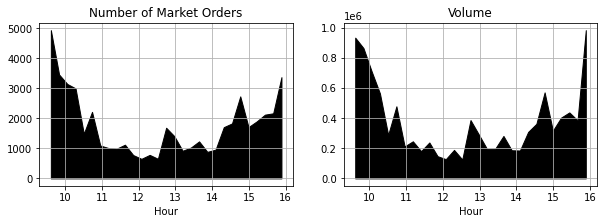

In [305]:
# The plot below shows that there is more 
# activity at the START/END of the day
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.fill_between(time_list, activity_list, color="black")
plt.grid(True)
plt.title("Number of Market Orders")
plt.xlabel("Hour")

plt.subplot(1,2,2)
plt.fill_between(time_list, volume_list, color="black")


plt.grid(True)
plt.title("Volume")
plt.xlabel("Hour")

Text(0, 0.5, 'Cumulative density P(X>x)')

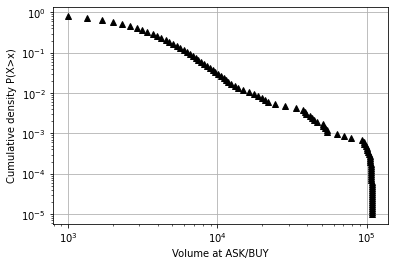

In [48]:
proba_list = 0.1**np.linspace(0.1,5,100)
vol_quantiles = np.quantile(np.concatenate([LOB.ask_size_1.values, LOB.bid_size_1.values]), 
                            q=1.-proba_list)

plt.plot(vol_quantiles, proba_list, "k^")
plt.yscale("log")
plt.xscale("log")
plt.grid(True)
plt.xlabel("Volume at ASK/BUY")
plt.ylabel("Cumulative density P(X>x)")

Text(0, 0.5, 'Cumulative density P(X>x)')

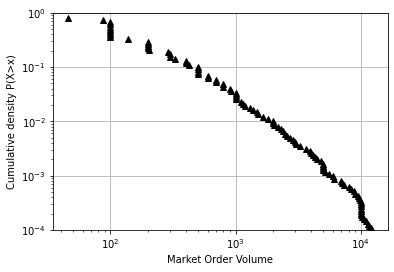

In [49]:
proba_list = 0.1**np.linspace(0.1,4.0,100)
vol_quantiles = np.quantile(message.vol[message.type == 4], 
                            q=1.-proba_list)

plt.plot(vol_quantiles, proba_list, "k^")
#plt.plot(vol_quantiles, 100000*vol_quantiles**(-5/2.), "r--")

plt.ylim( np.min(proba_list) ,1)
plt.yscale("log")
plt.xscale("log")
plt.grid(True)
plt.xlabel("Market Order Volume")
plt.ylabel("Cumulative density P(X>x)")

### Autocorrelation of the signs of market orders

In [36]:
market_orders_bool = message["type"] == 4
direction = message["direct"][market_orders_bool].values

In [37]:
direction

array([ 1,  1,  1, ...,  1, -1, -1], dtype=int64)

In [51]:
corr_function = []
lags = np.arange(1,100,1)
for k in lags:
    corr_function.append(np.corrcoef(direction[:-k],direction[k:])[0,1])

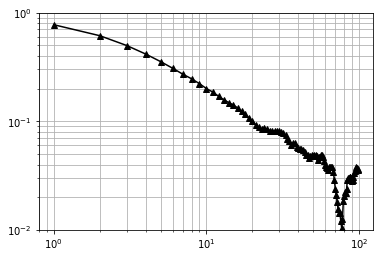

In [53]:
plt.plot(lags, corr_function, "k-^")
plt.ylim(10**-2,1)
plt.yscale("log")
plt.xscale("log")
plt.grid(which="both")